**Table of Contents**


          1.   Introduction and Solution Approach
          2.   Explanatory Data Analysis
          3.   Traning Models with only Tabular Data
                3.1. Logistic Regression
                3.2. Linear Regression
                3.3. Neural Network
          4.   Textual Data Analysis and Cleaning
          5.   Training Models with only Textual Data
          6.   Traning Model with mixed input 
          7.   Conclusion











**INTRODUCTION AND SOLUTION APPROACH**

In this notebook, a mixed input neural network model is introduced to predict the number of claps that a given medium post can get. There are several points that make the modelling of this problem challenging. First of all, in addition to the textual data(namely medium posts), there are bunch of other attributes belonging to the corresponding medium post. These two different variable sets should be included in the prediction model. Secondly, the provided training and test sets have different attribute set, which means that the one data set has to be converted to the other one. Thirdly, the target variable has too many zeros that it is not possible to approximate it to normal distribution by using a conversion technique. 

In order to overcome the first problem, keras functional API was used to combine different type of input sets. For the second point, more data is needed to be scrapped from medium.com. Therefore only the attributes in training set which also exist in the test set are used in the modelling. The third problem is solved by using a two step prediction approach. In the first step, a binary classification is performed to predict if the target variable is zero or higher than zero. In the second step, if the predcited target variable in the first step is not zero, then a regression model is used to predict the value of it. 

This notebook is organized as follows: In the first section, EDA, outlier handling and one hot encoding are carried out. As a next step, prediction models which use only tabular data as input are built. Thehese prediction models are used as a benchmark. The second section starts with the text data cleaning and tokenizing. Afterwards, an LSTM network is used to predict the target by using only the text data. In the third section, a deep learning model which uses both tabular and textual data to predict the target variable. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
#Text data cleaning
!pip install nltk
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
import re
from bs4 import BeautifulSoup

#Lexicon Sentiment Analysis
!pip install afinn
from afinn import Afinn

#Embeddings
from gensim.models import Word2Vec    

#Tokenizing text and squential model api
from nltk.tokenize.treebank import TreebankWordDetokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding,GRU, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Create a global variable to idicate whether the notebook is run in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules


# Configure variables pointing to directories and stored files 
if IN_COLAB:
    # Mount Google-Drive
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = '/content/drive/My Drive/Colab_Data_Files/' # adjust to Google drive folder with the data if applicable
else:
    DATA_DIR = '../../data/' # adjust to the directory where data is stored on your machine (if running the notebook locally)

Train = 'Train.csv'
Test = 'Test.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Read datasets from google drive
train_1=pd.read_csv(DATA_DIR + Train, sep=',',encoding='utf-8')
test_1=pd.read_csv(DATA_DIR + Test, sep=',',encoding='utf-8')

In [ ]:
train_1.head()

Some rows of the training data belong to the same medium post. I will drop the duplicates based on URL. I store the resulting table in train_orj because I want to keep original data same in order to avoid reading the training set from drive. 

In [5]:
#removal of duplicate observations
train_2=train_1.drop_duplicates(subset=['url'])
train_2=train_2.reset_index(drop=True) 
train_2.shape

(72337, 50)

**TABULAR DATA EXPLANATORY ANALYSIS**

In this section, I am analyzing the columns which don't contain textual data. The main challange is deciding which training columns to choose so that the resulting attribute set can be obtained from test set as well. 
I first get a general view of training and test set. The common attributes are author, responsesCreatedCount (responses), title(header), text, wordCount(length), and some of the publication details. 

In [6]:
print(train_2.isna().sum())
train_2.describe(include='all')

audioVersionDurationSec            0
codeBlock                      65973
codeBlockCount                     0
collectionId                   38546
createdDate                        0
createdDatetime                    0
firstPublishedDate                 0
firstPublishedDatetime             0
imageCount                         0
isSubscriptionLocked               0
language                           0
latestPublishedDate                0
latestPublishedDatetime            0
linksCount                         0
postId                             0
readingTime                        0
recommends                         0
responsesCreatedCount              0
socialRecommendsCount              0
subTitle                        2318
tagsCount                          0
text                               0
title                              1
totalClapCount                     0
uniqueSlug                         0
updatedDate                        0
updatedDatetime                    0
u

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,language,latestPublishedDate,latestPublishedDatetime,linksCount,postId,readingTime,recommends,responsesCreatedCount,socialRecommendsCount,subTitle,tagsCount,text,title,totalClapCount,uniqueSlug,updatedDate,updatedDatetime,url,vote,wordCount,publicationdescription,publicationdomain,publicationfacebookPageName,publicationfollowerCount,publicationname,publicationpublicEmail,publicationslug,publicationtags,publicationtwitterUsername,tag_name,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
count,72337.000000,6364,72337.000000,33791,72337,72337,72337,72337,72337.000000,72337,72337,72337,72337,72337.000000,72337,72337.000000,72337.000000,72337.000000,72337.000000,70019,72337.000000,72337,72336,72337.000000,72337,72337,72337,72337,72337,72337.000000,33630,12672,24376,0.0,33630,24835,33630,31659,29002,72337,72337,72337,72337.000000,72337,56275,72337,72337,72337.000000,72337.000000,72337.0
unique,NaN,6230,NaN,6527,741,72209,610,71406,NaN,2,52,577,72158,NaN,72337,NaN,NaN,NaN,NaN,65673,NaN,72024,70275,NaN,72337,431,71827,72337,2,NaN,6506,1062,3836,NaN,6507,5035,6512,5697,4861,3874,3874,3874,NaN,31021,22352,31317,31317,NaN,NaN,NaN
top,NaN,Recommend & share..\n,NaN,7f60cf5620c9,2018-08-27,2018-02-27 22:18:17,2018-08-27,2018-01-01 00:00:00,NaN,False,en,2018-06-05,2018-05-25 18:01:01,NaN,1d18bb78f35b,NaN,NaN,NaN,NaN,Introduction,NaN,Learn Colors for Children with Little Monsters...,10 new things to read in AI,NaN,paper-review-of-zfnet-the-winner-of-ilsvlc-201...,2018-06-20,2018-05-14 09:47:03,https://medium.com/s/story/ten-from-the-weeken...,False,NaN,"Sharing concepts, ideas, and codes.",towardsdatascience.com,towardsdatascience,NaN,Towards Data Science,stories@amipublications.com,towards-data-science,"DATA SCIENCE,MACHINE LEARNING,ARTIFICIAL INTEL...",TDataScience,Machine Learning,machine-learning,Machine Learning,NaN,Synced,AI Technology & Industry Review - www.syncedre...,960feca52112,Synced,NaN,NaN,NaN
freq,NaN,47,NaN,3836,294,2,328,7,NaN,70276,66380,432,4,NaN,1,NaN,NaN,NaN,NaN,341,NaN,20,62,NaN,1,1099,40,1,72235,NaN,3836,3836,3836,NaN,3836,1386,3836,3836,3836,17096,17096,17096,NaN,378,378,378,378,NaN,NaN,NaN
mean,0.495072,NaN,1.197492,NaN,NaN,NaN,NaN,NaN,3.608637,NaN,NaN,NaN,NaN,6.509684,NaN,3.949488,23.565146,0.847035,0.064462,NaN,4.293294,NaN,NaN,162.633811,NaN,NaN,NaN,NaN,NaN,901.511744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57969.335057,NaN,NaN,NaN,NaN,1652.917760,282.447738,20181104.0
std,22.198322,NaN,6.851056,NaN,NaN,NaN,NaN,NaN,5.415534,NaN,NaN,NaN,NaN,11.480716,NaN,3.497320,265.821608,14.319444,0.281705,NaN,1.192822,NaN,NaN,1813.480195,NaN,NaN,NaN,NaN,NaN,863.265572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61017.861531,NaN,NaN,NaN,NaN,12490.304716,1514.427745,0.0
min,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.003774,0.000000,0.000000,0.000000,NaN,1.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,20181104.0
25%,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,1.886792,0.000000,0.000000,0.000000,NaN,4.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,402.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23410.000000,NaN,NaN,NaN,NaN,8.000000,3.000000,20181104.0
50%,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,4.000000,NaN,3.145597,2.000000,0.000000,0.000000,NaN,5.000000,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,703.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51320.000000,NaN,NaN,NaN,NaN,52.000000,22.000000,20181104.0
75%,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,8.000000,NaN,4.979245,7.000000,0.000000,0.000000,NaN,5.000000,NaN,NaN,61.000000,NaN,NaN,NaN,NaN,NaN,1138.000000,NaN,NaN,NaN,NaN,

In [7]:
test_1.info()
test_1.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          514 non-null    int64 
 1   index               514 non-null    int64 
 2   Author              514 non-null    object
 3   PublicationDetails  514 non-null    object
 4   Responses           432 non-null    object
 5   Header              506 non-null    object
 6   Text                514 non-null    object
 7   Length              514 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 32.2+ KB


,Unnamed: 0,index,Author,PublicationDetails,Responses,Header,Text,Length
0,0,0,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 31, 2017",627 responses,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401
1,1,1,Noam Levenson,"Noam Levenson in HackerNoon.comDec 6, 2017",156 responses,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972


I keep the common columns and columns which don't exist in test set but can be obtained from the test set.  Language, image count and reading time can be derived by using the text column in the test set. I also keep the textual data in this training set but it will not be part of the model in this section

In [8]:
#Decide which columns in trainset to keep
keep_columns=['responsesCreatedCount','imageCount','wordCount','readingTime','firstPublishedDate','language','publicationname','totalClapCount','text','title'] 
train=train_2[keep_columns]
train.describe(include='all')

,responsesCreatedCount,imageCount,wordCount,readingTime,firstPublishedDate,language,publicationname,totalClapCount,text,title
count,72337.000000,72337.000000,72337.000000,72337.000000,72337,72337,33630,72337.000000,72337,72336
unique,NaN,NaN,NaN,NaN,610,52,6507,NaN,72024,70275
top,NaN,NaN,NaN,NaN,2018-08-27,en,Towards Data Science,NaN,Learn Colors for Children with Little Monsters...,10 new things to read in AI
freq,NaN,NaN,NaN,NaN,328,66380,3836,NaN,20,62
mean,0.847035,3.608637,901.511744,3.949488,NaN,NaN,NaN,162.633811,NaN,NaN
std,14.319444,5.415534,863.265572,3.497320,NaN,NaN,NaN,1813.480195,NaN,NaN
min,0.000000,0.000000,0.000000,0.003774,NaN,NaN,NaN,0.000000,NaN,NaN
25%,0.000000,1.000000,402.000000,1.886792,NaN,NaN,NaN,0.000000,NaN,NaN
50%,0.000000,2.000000,703.000000,3.145597,NaN,NaN,NaN,5.000000,NaN,NaN
75%,0.000000,5.000000,1138.000000,4.979245,NaN,NaN,NaN,61.000000,NaN,NaN


I noticed that there are articles which have the same title. I checked those posts and they just have the same title, the content is different. Therefore the duplicate cleaning is successfull.


In [9]:
train['title'].value_counts()

10 new things to read in AI                                62
11 new things to read in AI                                49
Artificial Intelligence                                    28
12 new things to read in AI                                25
13 new things to read in AI                                23
                                                           ..
Panorama de inversión en Startups                           1
Data Science Vs Data Analytics : What’s the difference?     1
Generative AI for Content Creation                          1
Self-Driving Car Series                                     1
REPOST: Best Journaling App — Reflecty                      1
Name: title, Length: 70275, dtype: int64

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72337 entries, 0 to 72336
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   responsesCreatedCount  72337 non-null  int64  
 1   imageCount             72337 non-null  int64  
 2   wordCount              72337 non-null  int64  
 3   readingTime            72337 non-null  float64
 4   firstPublishedDate     72337 non-null  object 
 5   language               72337 non-null  object 
 6   publicationname        33630 non-null  object 
 7   totalClapCount         72337 non-null  int64  
 8   text                   72337 non-null  object 
 9   title                  72336 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 5.5+ MB


Before moving on, I will convert test set into the same format with training set. 

In the code section below, I search for the keyword img in the html content to detect the number of images.

In [11]:
image_test =[BeautifulSoup(i, 'html.parser').findAll("img") for i in test_1['Text']]

n_image_test=[]
for elem in image_test:
  n_image_test.append(len(elem))   

test_1['imageCount']= n_image_test

Responses column in the test set is in format "10 responses". I remove the "responses" string, fill na'as with average response in trainset and adjust the format of the numbers.  

In [12]:
responses = test_1["Responses"]

In [13]:
responses_new = []
for i in responses:
  #print(i)
  if type(i) == float:
    i = str(i)
    if i is not 'nan':
      responses_new.append(i.split()[0])
  else:
    responses_new.append(i.split()[0])


In [14]:
test_1['responsesCreatedCount'] = responses_new
test_1=test_1.drop('Responses',axis=1)

In [15]:
test_1['responsesCreatedCount']=[1 if i =='nan' else i for i in test_1['responsesCreatedCount']]
test_1['responsesCreatedCount']=[re.sub("[^\d\.]", "", i) if isinstance(i,str) else i for i in test_1['responsesCreatedCount']]

In [16]:
test_1['responsesCreatedCount']=test_1['responsesCreatedCount'].astype(int)

In [17]:
pip install langdetect

In [18]:
from langdetect import detect

In [19]:
lang = detect(str(test_1['Text']))

In [20]:
language = []
for i in test_1['Text']:
  #print(detect(i))
  language.append(detect(i))

test_1['language'] = language
test_1.head(2)

,Unnamed: 0,index,Author,PublicationDetails,Header,Text,Length,imageCount,responsesCreatedCount,language
0,0,0,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 31, 2017",Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401,10,627,en
1,1,1,Noam Levenson,"Noam Levenson in HackerNoon.comDec 6, 2017",NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972,9,156,en


PublicationDetails is the hardest column to convert. I would like to extract the publication name out of this columns. I had to first partition the column based on the upper case letters so that date will be splitted from publication .name.

In [21]:
test_1['Date']=[re.findall('[A-Z][^A-Z]*', i) for i in test_1['PublicationDetails']]
test_1['Date']=[i[-1] for i in test_1['Date']]
for i in range(len(test_1)):
  test_1['PublicationDetails'][i]=re.sub(test_1['Date'][i],"",test_1['PublicationDetails'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Most of the records in PublicationDetails includes the name of the author as well. In the code below, author name is deleted from publicationDetails column. 

In [22]:
for i in range(len(test_1)):
  test_1['PublicationDetails'][i]=re.sub(test_1['Author'][i],"",test_1['PublicationDetails'][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
test_1['PublicationDetails']=[re.sub(r'^[^_]*in'," ",i) for i in test_1['PublicationDetails']]

In [24]:
test_1['PublicationDetails']=[re.sub(r'HackerNoon.com',"HN",i) for i in test_1['PublicationDetails']]#find all Hacker Noon publications, name them HN
test_1['PublicationDetails']=[re.sub(r'Towards Data Science',"TDS",i) for i in test_1['PublicationDetails']] #find all Towards Data Science publications name them TDS
test_1['PublicationDetails']=[re.sub(r'Netflix TechBlog',"NT",i) for i in test_1['PublicationDetails']] #find all Towards Data Science publications name them TDS
test_1['PublicationDetails']=[i.replace(" ","") for i in test_1['PublicationDetails']]#remove white space

In [25]:
for i in range(len(test_1)):
  if test_1['PublicationDetails'][i]!='HN' and test_1['PublicationDetails'][i]!='TDS'and test_1['PublicationDetails'][i]!='NT':
    if len(test_1['PublicationDetails'][i])>3:
      test_1['PublicationDetails'][i]='others'
    else: test_1['PublicationDetails'][i]='author'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [26]:
test_1.head(2)


,Unnamed: 0,index,Author,PublicationDetails,Header,Text,Length,imageCount,responsesCreatedCount,language,Date
0,0,0,Daniel Jeffries,HN,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401,10,627,en,"Jul 31, 2017"
1,1,1,Noam Levenson,HN,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972,9,156,en,"Dec 6, 2017"


In [27]:
test_1=test_1.rename(columns={'PublicationDetails':'publicationname','Header':'title','Text':'text','Length':'wordCount'})

In [28]:
test_2=test_1.drop(['Unnamed: 0','index','Author'], axis=1)

In [29]:
test_2.head(2)

,publicationname,title,text,wordCount,imageCount,responsesCreatedCount,language,Date
0,HN,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401,10,627,en,"Jul 31, 2017"
1,HN,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972,9,156,en,"Dec 6, 2017"


OUTLIER HANDLING AND NUMARICAL ATTRIBUTE ANALYSIS

In order to get a better explanatory analysis in the upcoming sections, I wanted to clean the outliers in the numerical attributes. First I checked the distribution of the target variable. It is highly right scewed and has a long tail. It would be helpful to log transform the target variable so that the prediction model is also able to predict high number of claps more effectively. Boxplot of target variable also points out so many outliers. I will first go to the website of those outlier posts and see if the number of claps on the website is the same as in our data set. 

Text(0.5, 0, 'Claps')

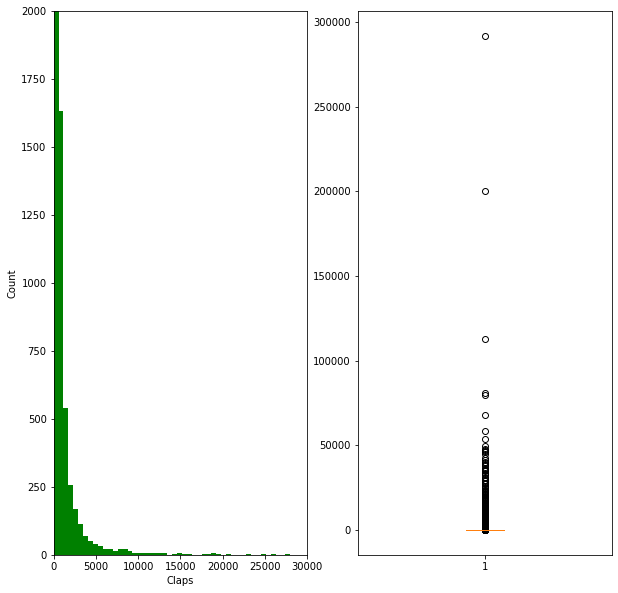

In [30]:
figure1, ax1 = plt.subplots(ncols=2,figsize=(10,10))

ax1[0].hist(train['totalClapCount'], color='green', bins = 500)
ax1[1].boxplot(train['totalClapCount']) 

ax1[0].axis(ymin=0,ymax=2000)
ax1[0].axis(xmin=0,xmax=30000)
ax1[0].set_ylabel('Count')
ax1[0].set_xlabel('Claps')


In [31]:
pd.options.display.max_colwidth = 200
train_2.loc[train_2['totalClapCount']>100000,'url']

31826    https://medium.com/s/story/my-name-is-wil-wheaton-i-live-with-chronic-depression-and-generalized-anxiety-i-am-not-ashamed-8f693f9c0af1
34751                                                        https://medium.com/s/story/the-most-important-skill-nobody-taught-you-9b162377ab77
63255                                           https://medium.freecodecamp.org/we-fired-our-top-talent-best-decision-we-ever-made-4c0a99728fde
Name: url, dtype: object

It seems like the values are real and they are just the random variation in the data. Although the data doesn't look like normally distributed, z score outlier elimination may give further ideas. There are 249 data points which have z score bigger than 3 standard deviation. However, this number sounds still too much to me, because outliers should be observations which are rare. By looking at the boxplot, claps which are more than 60k can be treated as outliers. For now, I will keep the target variable as it is and will decide to truncate or approximate outliers after getting the prediction results. I don't think that outliers should be approximated to some other number or should be deleted because outliers are not result of wrong data entry or wrong measurement in our case

In [32]:
train_z=(train['totalClapCount'] - train['totalClapCount'].mean())/train['totalClapCount'].std()
sum(train_z>3)

249

Before moving on, it would be a good idea to log transform the target variable and check the distribution. Unfortunately the transformed values don't approximate a normal distribution. The reason is the high number of 0 Claps. 

Text(0.5, 0, 'Claps')

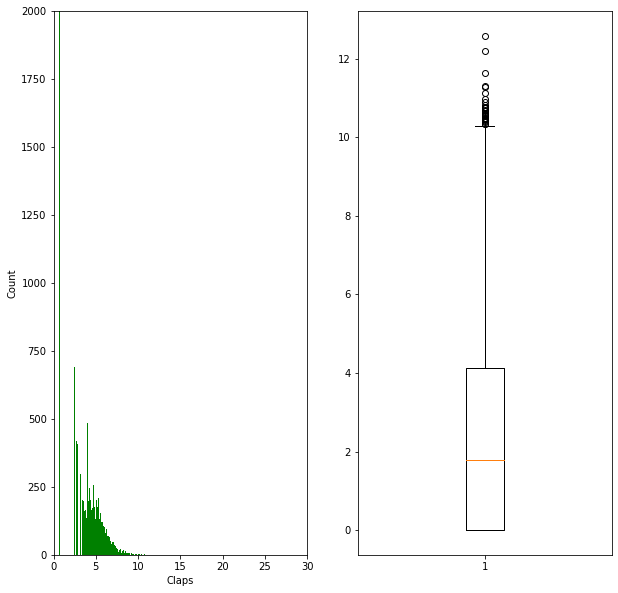

In [33]:
totalClapCountLog=np.log(train['totalClapCount'].values+1)
figure2, ax2 = plt.subplots(ncols=2,figsize=(10,10))

ax2[0].hist(totalClapCountLog, color='green',bins=500)
ax2[1].boxplot(totalClapCountLog) 

ax2[0].axis(ymin=0,ymax=2000)
ax2[0].axis(xmin=0,xmax=30)
ax2[0].set_ylabel('Count')
ax2[0].set_xlabel('Claps')

responsesCreatedCount has a very smiliar histogram and boxplot to target variable. When the outliers are cleaned by using interquartile range method,Only 0 responses remained. Moreoever, the outlier values are correct, which means they are just random variation in the data as in the case with target variable. responses is highly corrolated with the target so I want it to be in my training set. Therefore I will keep it without cleaning outliers.


(0.0, 500.0, 0.0, 1000.0)

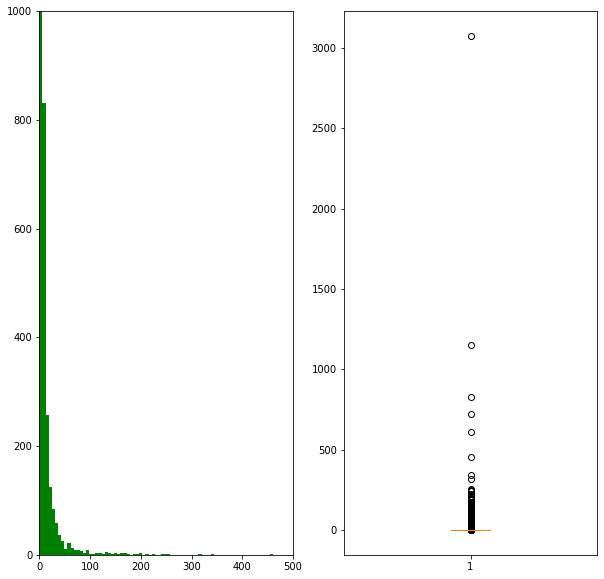

In [34]:
figure3, ax3 = plt.subplots(ncols=2,figsize=(10,10))

ax3[0].hist(train['responsesCreatedCount'], color='green',bins=500)
ax3[1].boxplot(train['responsesCreatedCount']) 
ax3[0].axis(ymin=0,ymax=1000)
ax3[0].axis(xmin=0,xmax=500)

In [35]:
#check if the outlier values are real
pd.options.display.max_colwidth = 200
train_2.loc[train_2['responsesCreatedCount']>1000,'url']

13184                      https://medium.com/s/story/the-snips-air-token-sale-4511320d68d0
34751    https://medium.com/s/story/the-most-important-skill-nobody-taught-you-9b162377ab77
Name: url, dtype: object

(0.0, 10000.0, 0.0, 5000.0)

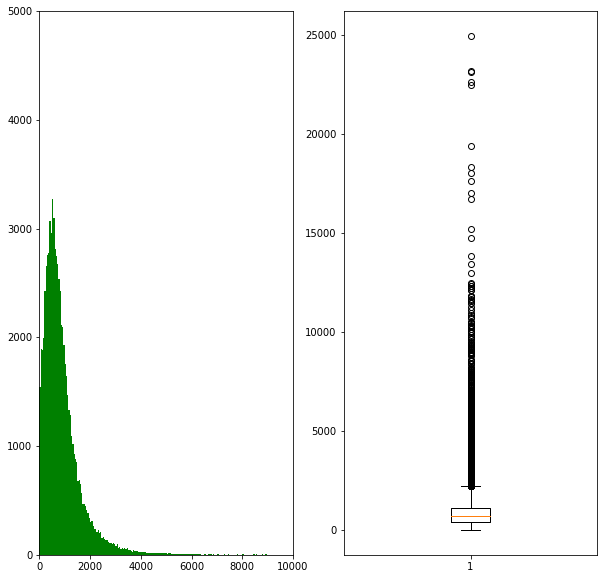

In [36]:
figure4, ax4 = plt.subplots(ncols=2,figsize=(10,10))

ax4[0].hist(train['wordCount'], color='green',bins=500)
ax4[1].boxplot(train['wordCount']) 
ax4[0].axis(ymin=0,ymax=5000)
ax4[0].axis(xmin=0,xmax=10000)

(0.0, 200.0, 0.0, 5000.0)

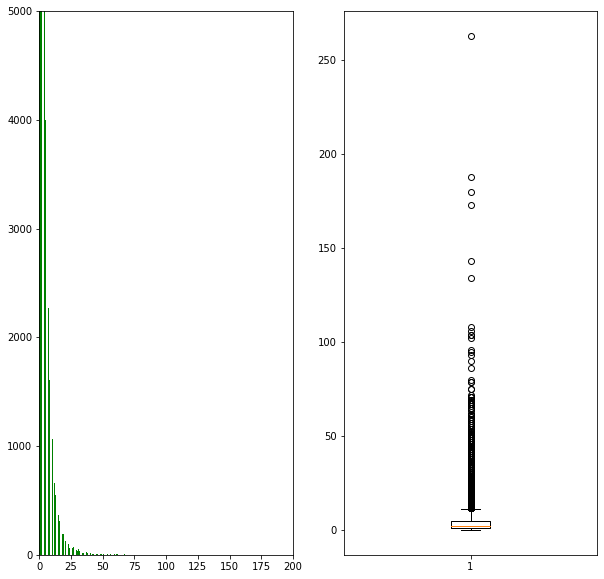

In [37]:
figure5, ax5 = plt.subplots(ncols=2,figsize=(10,10))

ax5[0].hist(train['imageCount'], color='green',bins=500)
ax5[1].boxplot(train['imageCount']) 
ax5[0].axis(ymin=0,ymax=5000)
ax5[0].axis(xmin=0,xmax=200)

I used snspairplot in order to see how the attributes are pairwise distributed.It looks like responsescreatedCount is highly corrolated with our target. Scatter plot of responsesCreatedCount points out an outlier observation which is around 3000 responses. Moreover, the first row of the pairplot indicates that the  claps which are higher than 60k are also outliers. 
Reading time and word count probably has corrolation very close to 1. It will be sufficient to keep any one of them in our traning set. Test data doesn't have reading time but it has length, which I think number of words in the text. Therefore I will keep word count in the traning set. Before moving on, I will truncate the outliers I observed here, I will store the resulting training set in train_noOutliers and then I will calculate the corrolation between the attributes via heatmap

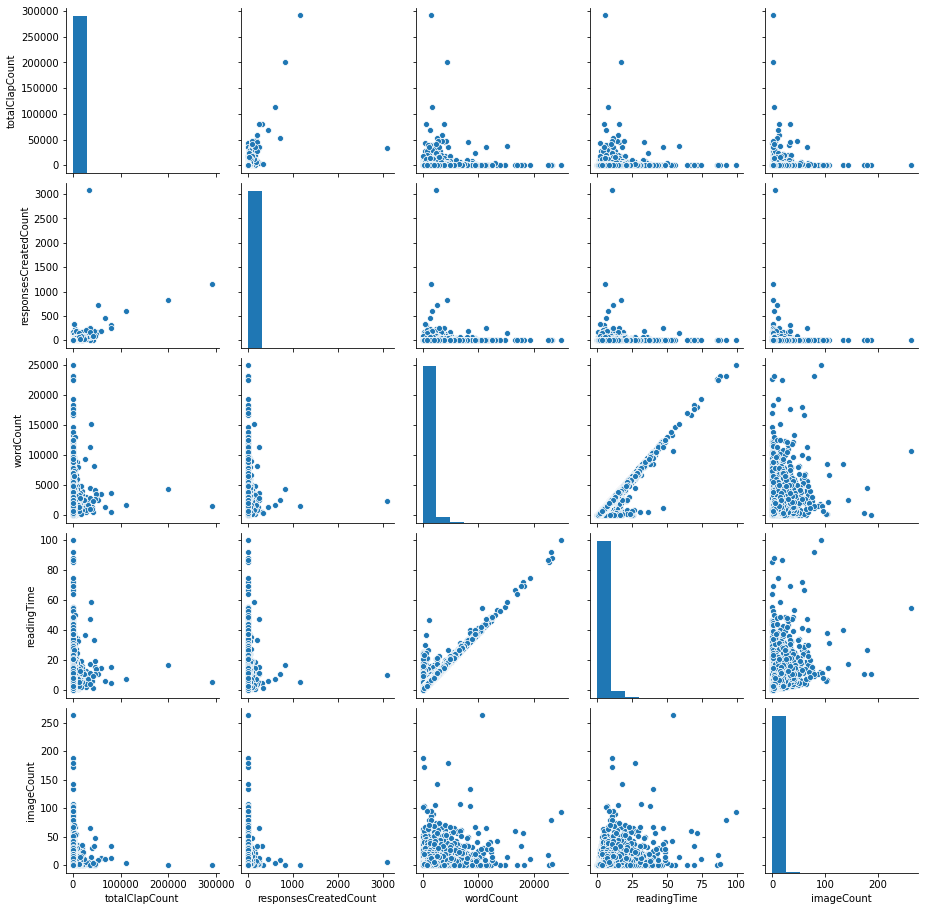

In [38]:
sns.pairplot(train[['totalClapCount','responsesCreatedCount','wordCount','readingTime','imageCount']])


Here I create the train set train_noOutlier which doesn't have the outliers that I observed above. Actually outliers shouldn't be removed because they are not due to data entry or measurement mistakes. However, they create a huge noise in the data. Therefore I will keep two training sets, one is with outliers the other one is without outliers

In [30]:
train_noOutlier=train.loc[train['totalClapCount']<60000] #remove the data points having more than 60k claps
train_noOutlier=train_noOutlier.loc[train_noOutlier['responsesCreatedCount']<2000]#remove the data points having more than 2k responses
train_noOutlier=train_noOutlier.loc[train_noOutlier['imageCount']<150] #remove the data points having more than 150 images
train_noOutlier=train_noOutlier.loc[train_noOutlier['wordCount']<20000] #remove the data points having more than 20k words

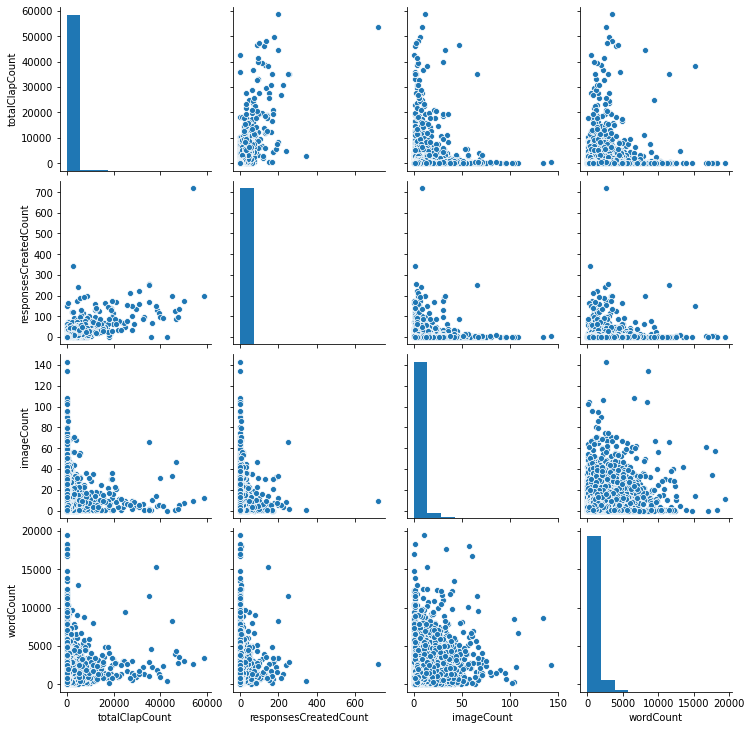

In [40]:
sns.pairplot(train_noOutlier[['totalClapCount','responsesCreatedCount','imageCount','wordCount']])

The below heatmaps show that our target variable is only corrolated with responsesCreatedCount. The relationship between these two is defined better in train_noOutlier set,i.e. corralation is 0.724. It is expected that train_noOutlier gives better predictions, however, this may not be the case depending on the test data

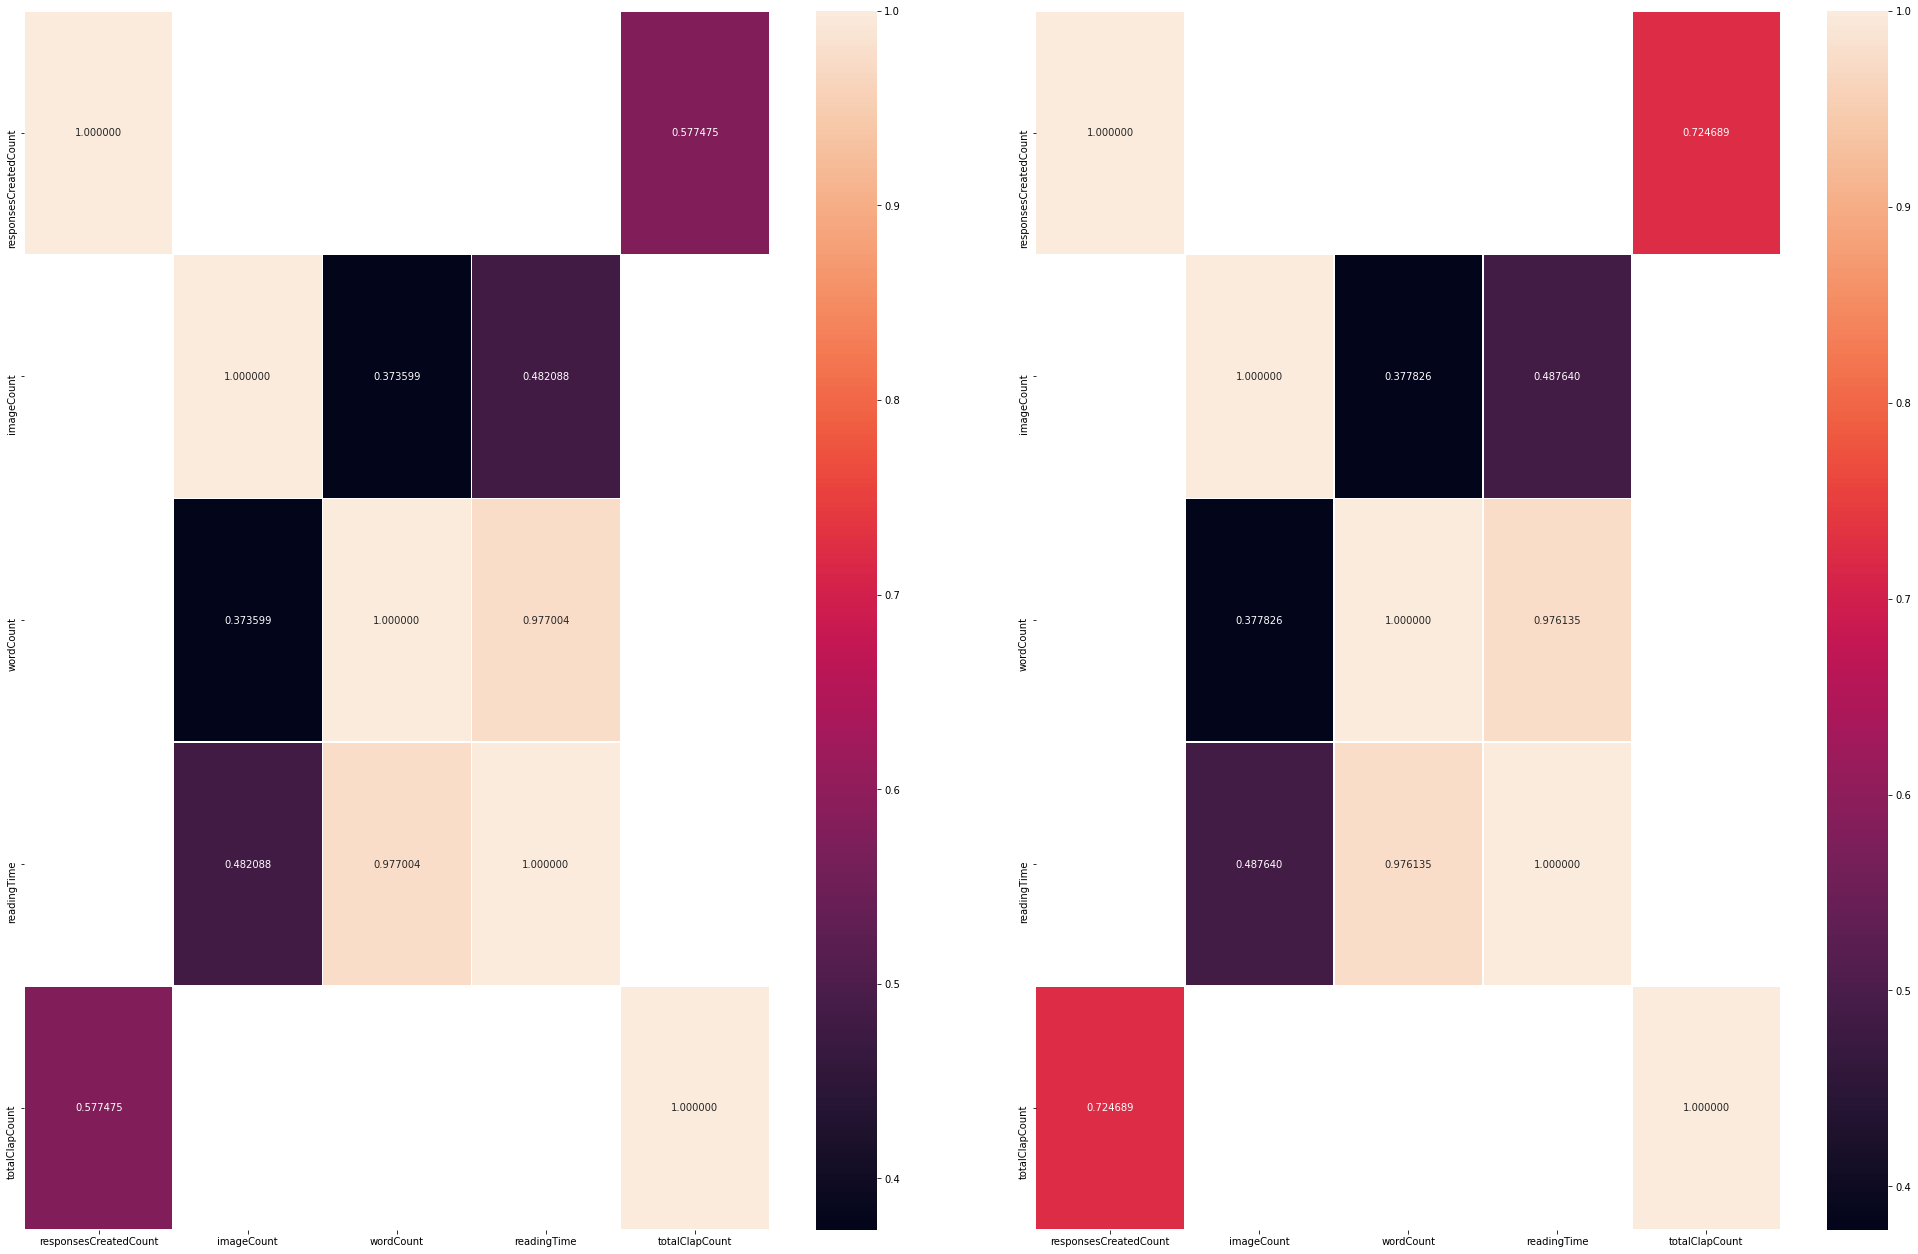

In [41]:
corr1= train.corr()
corr2= train_noOutlier.corr()
f,ax = plt.subplots(1,2,figsize=(30, 20))
sns.heatmap(corr1[(corr1 >= 0.30) | (corr1 <= -0.30)],
            annot=True,linewidth=.5,fmt='1f',ax=ax[0]);
sns.heatmap(corr2[(corr2 >= 0.30) | (corr2 <= -0.30)],
            annot=True,linewidth=.5,fmt='1f',ax=ax[1]);
f.tight_layout(pad=10.0)

HANDLING OF CATEGORICAL AND TIME DATA

Here, I will convert date-time column into month and day columns. Maybe there will be a relationship between target and time that the post is published.

In [31]:
train['firstPublishedDate']= pd.to_datetime(train['firstPublishedDate']) #It is needed to convert dataype to datetime so that I can divide date time into months and days
train['Month'] = train['firstPublishedDate'].dt.month.astype('category') #Get the month of the date
train['Weekday'] = train['firstPublishedDate'].dt.day_name().astype('category') #Get the day of the date

#The above same procedure is repeted for the train set without ouliers
train_noOutlier['firstPublishedDate']= pd.to_datetime(train_noOutlier['firstPublishedDate']) 
train_noOutlier['Month'] = train_noOutlier['firstPublishedDate'].dt.month.astype('category')
train_noOutlier['Weekday'] = train_noOutlier['firstPublishedDate'].dt.day_name().astype('category')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [32]:
train.loc[(train['Month'].isin([12,1,2])), 'MonthCat'] = 'winter'
train.loc[(train['Month'].isin([3,4,5])), 'MonthCat'] = 'spring' 
train.loc[(train['Month'].isin([6,7,8])), 'MonthCat'] = 'summer' 
train.loc[(train['Month'].isin([9,10,11])), 'MonthCat'] = 'fall' 


train_noOutlier.loc[(train_noOutlier['Month'].isin([12,1,2])), 'MonthCat'] = 'winter' 
train_noOutlier.loc[(train_noOutlier['Month'].isin([3,4,5])), 'MonthCat'] = 'spring' 
train_noOutlier.loc[(train_noOutlier['Month'].isin([6,7,8])), 'MonthCat'] = 'summer' 
train_noOutlier.loc[(train_noOutlier['Month'].isin([9,10,11])), 'MonthCat'] = 'fall' 


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


The relationships between day/month and target variable are plotted below. Unfortunately there seems no clear relationship in both train and tran_noOutlier

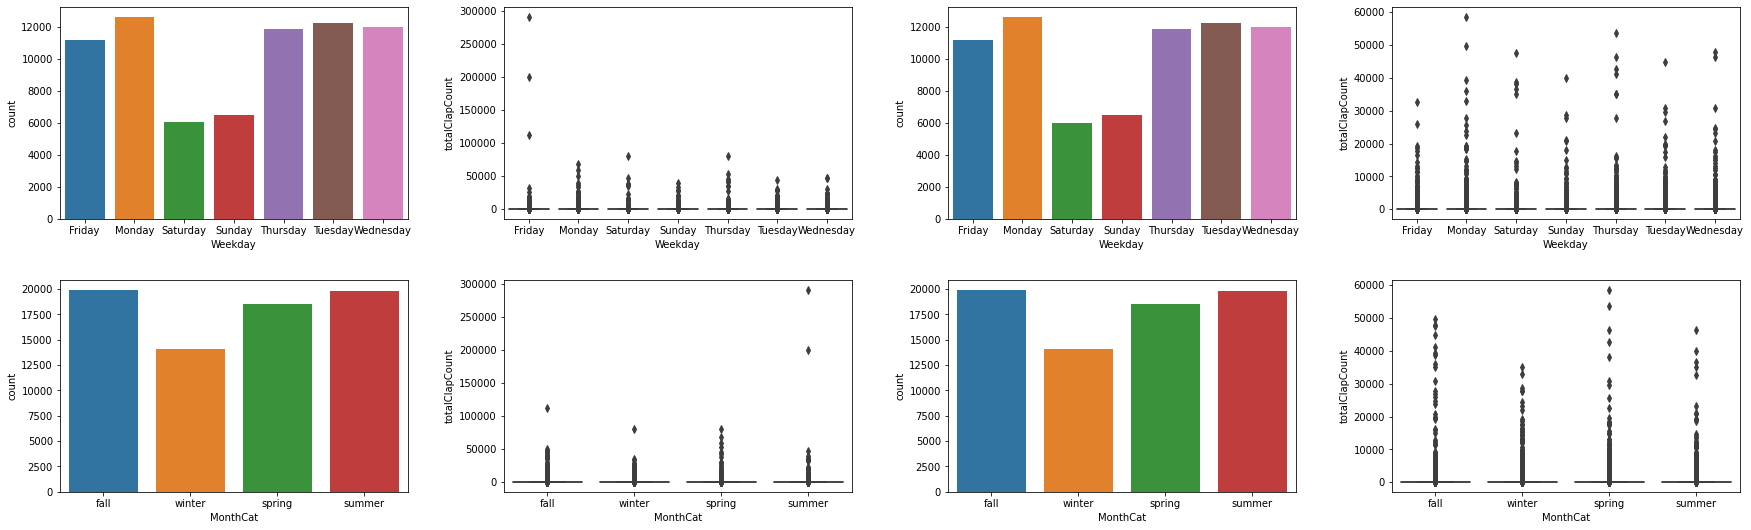

In [44]:
fig1, axs1 = plt.subplots(nrows=2,ncols=4)
fig1.set_size_inches(25,8)
sns.countplot(data = train, x = 'Weekday', ax=axs1[0,0])
sns.boxplot(data = train, x = 'Weekday', y='totalClapCount',ax=axs1[0,1])
sns.countplot(data = train, x = 'MonthCat', ax=axs1[1,0])
sns.boxplot(data = train, x = 'MonthCat', y='totalClapCount',ax=axs1[1,1])

sns.countplot(data = train_noOutlier, x = 'Weekday', ax=axs1[0,2])
sns.boxplot(data = train_noOutlier, x = 'Weekday', y='totalClapCount',ax=axs1[0,3])
sns.countplot(data = train_noOutlier, x = 'MonthCat', ax=axs1[1,2])
sns.boxplot(data = train_noOutlier, x = 'MonthCat', y='totalClapCount',ax=axs1[1,3])

fig1.tight_layout(pad=3.0)


The posts can be categorized in two class, English and non-English. I included the non-English text in the nlp analysis, therefore I keep language column in the dataset. English texts have the higher number of claps as expected. language column may be helpful for training

In [33]:
train['language']=['en' if i == 'en' else 'other' for i in list(train['language'])]
train['language']=train['language'].astype('category')

train_noOutlier['language']=['en' if i == 'en' else 'other' for i in list(train_noOutlier['language'])]
train_noOutlier['language']=train_noOutlier['language'].astype('category')

test_2['language']=['en' if i == 'en' else 'other' for i in list(test_2['language'])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


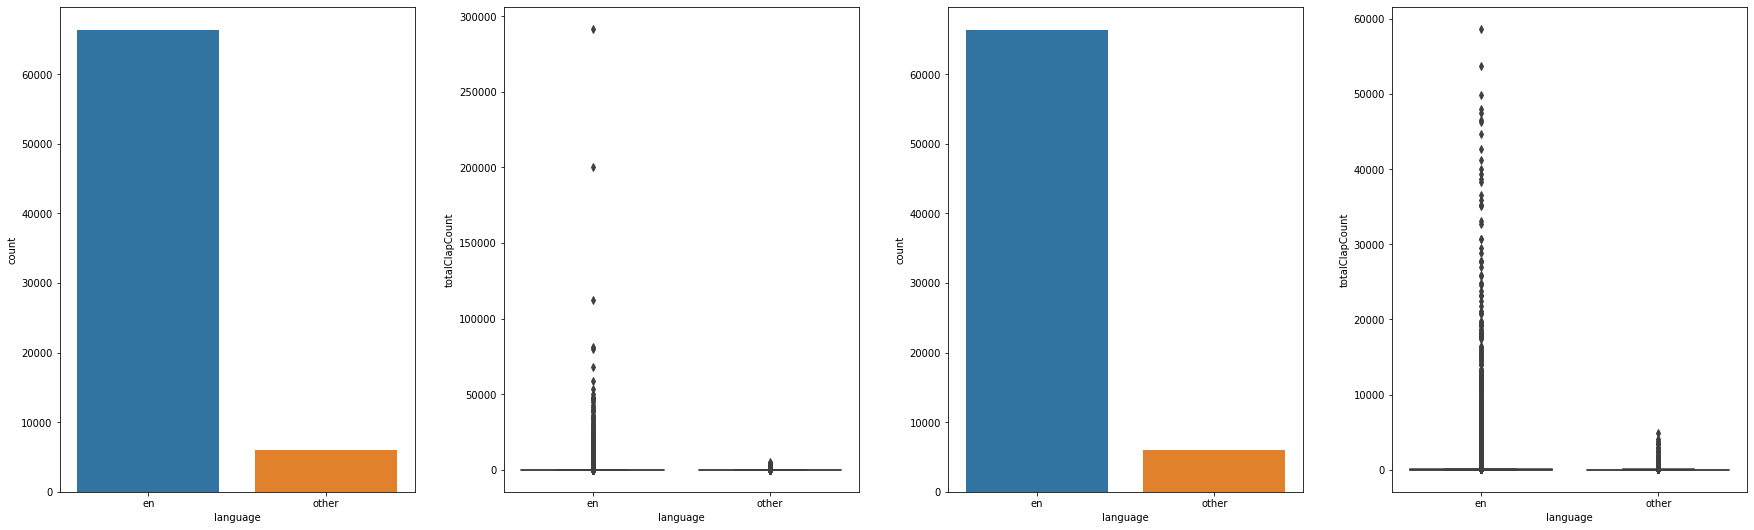

In [46]:
fig2, axs2 = plt.subplots(ncols=4)
fig2.set_size_inches(25,8)
sns.countplot(data = train, x = 'language', ax=axs2[0])
sns.boxplot(data = train, x = 'language', y='totalClapCount',ax=axs2[1])
sns.countplot(data = train_noOutlier, x = 'language', ax=axs2[2])
sns.boxplot(data = train_noOutlier, x = 'language', y='totalClapCount',ax=axs2[3])
fig2.tight_layout(pad=3.0)

Publication name has too many na records. I have checked those medium posts with and without na and what I realized is that if a medium post is not published in a publication, then simply there is no record for publication name column in the dataset.That is to say, na's are not result of bad scrape of the website. Therefore I filled those na's with author names. Further I divided publication names into 5 categories, namely author, Towards Data Science, Hacker Noon, Netflix Techblock and others. These categories(except Netflix Techblock) constitute the majority of the records. This is why I categorized publicationname into these categories

In [34]:
counts=pd.DataFrame(train['publicationname'].value_counts())
counts.reset_index(inplace=True)
counts.head(10)

,index,publicationname
0,Towards Data Science,3836
1,Hacker Noon,1253
2,Becoming Human: Artificial Intelligence Magazine,758
3,Data Driven Investor,659
4,Chatbots Life,479
5,SyncedReview,367
6,Chatbots Magazine,359
7,The Startup,317
8,Planeta Chatbot : todo sobre los Chatbots y la...,308
9,DEEPAERODRONES,273


In [35]:
train['publicationname'].fillna('author',inplace = True)
# train['publicationnamecat']=['author' if i == 'author' else train['publicationname'] for i in list(train['publicationname'])]

train['publicationnamecat'] = 'others' #set default value to others for the new categorical variable
train.loc[(train['publicationname'] == 'author'), 'publicationnamecat'] = 'author' # assign author if it is author
train.loc[(train['publicationname'] == 'Towards Data Science'), 'publicationnamecat'] = 'TDS' # assign TDS if publicationname is Towards Data Science
train.loc[(train['publicationname'] == 'Hacker Noon'), 'publicationnamecat'] = 'HN' # assign HN if publicationname is Hacker Noon
train.loc[(train['publicationname'] == 'Netflix TechBlog'), 'publicationnamecat'] = 'NT' # assign NT if publicationname is Netflix Techblock


train_noOutlier['publicationname'].fillna('author',inplace = True)
# train_noOutlier['publicationnamecat']=['author' if i == 'author' else train_noOutlier['publicationname'] for i in list(train_noOutlier['publicationname'])]

train_noOutlier['publicationnamecat'] = 'others' 
train_noOutlier.loc[(train_noOutlier['publicationname'] == 'author'), 'publicationnamecat'] = 'author' 
train_noOutlier.loc[(train_noOutlier['publicationname'] == 'Towards Data Science'), 'publicationnamecat'] = 'TDS' 
train_noOutlier.loc[(train_noOutlier['publicationname'] == 'Hacker Noon'), 'publicationnamecat'] = 'HN'
train_noOutlier.loc[(train_noOutlier['publicationname'] == 'Netflix TechBlog'), 'publicationnamecat'] = 'NT'

#Column names in test and train sets should be the same
test_2['publicationnamecat']=test_2['publicationname']
test_2=test_2.drop('publicationname',axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Median of Netflix Techblock is higher than the other categories, which means most of the records belonging to NT is assosciated with high number of claps. The other categories are associated with the outliers in the target variable, which may be helpful to predict the extremely high number of claps

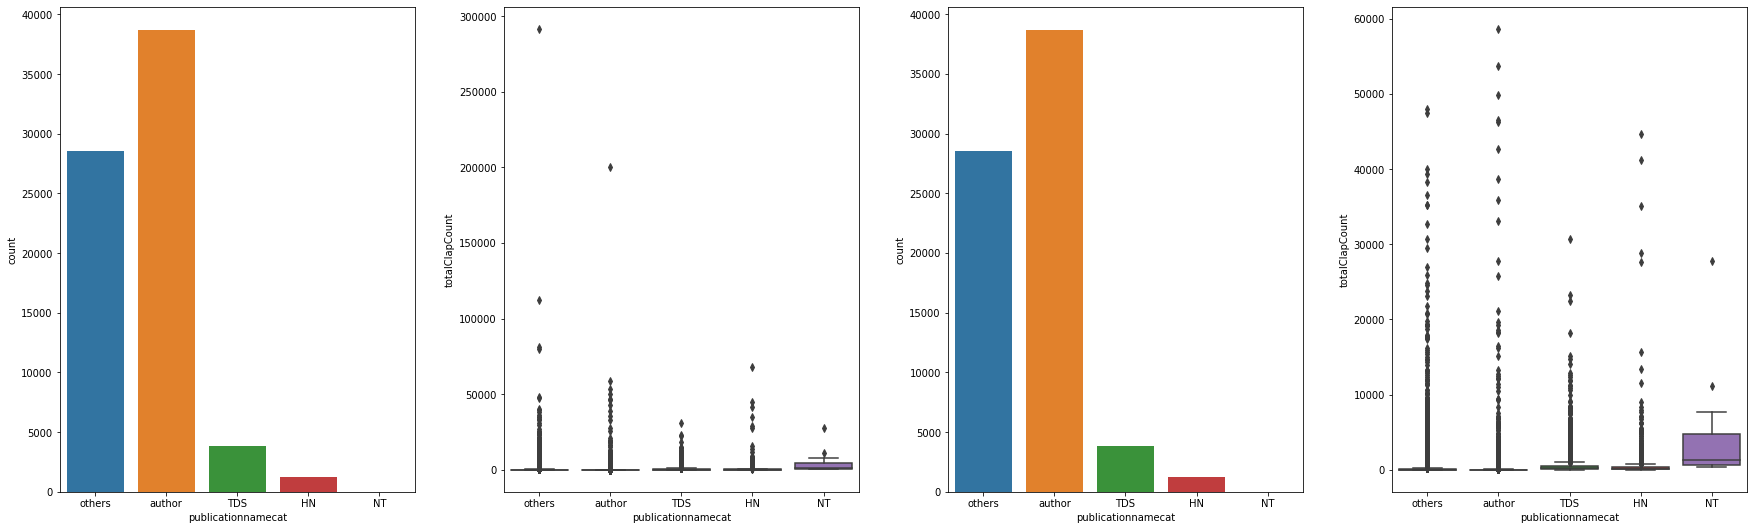

In [36]:
fig3, axs3 = plt.subplots(ncols=4)
fig3.set_size_inches(25,8)
sns.countplot(data = train, x = 'publicationnamecat', ax=axs3[0])
sns.boxplot(data = train, x = 'publicationnamecat', y='totalClapCount',ax=axs3[1])

sns.countplot(data = train_noOutlier, x = 'publicationnamecat', ax=axs3[2])
sns.boxplot(data = train_noOutlier, x = 'publicationnamecat', y='totalClapCount',ax=axs3[3])
fig3.tight_layout(pad=3.0)


In [50]:
print(train.info()), print(train_noOutlier.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72337 entries, 0 to 72336
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   responsesCreatedCount  72337 non-null  int64         
 1   imageCount             72337 non-null  int64         
 2   wordCount              72337 non-null  int64         
 3   readingTime            72337 non-null  float64       
 4   firstPublishedDate     72337 non-null  datetime64[ns]
 5   language               72337 non-null  category      
 6   publicationname        72337 non-null  object        
 7   totalClapCount         72337 non-null  int64         
 8   text                   72337 non-null  object        
 9   title                  72336 non-null  object        
 10  Month                  72337 non-null  category      
 11  Weekday                72337 non-null  category      
 12  MonthCat               72337 non-null  object        
 13  p

(None, None)

In [37]:
#there is an na in title column, I simply dropped that record
train = train.dropna()
train_noOutlier=train_noOutlier.dropna()
train.reset_index(drop=True, inplace=True)
train_noOutlier.reset_index(drop=True, inplace=True)

In [38]:
#I don't need reading time because it is highly corrolated with wordCount. Month and Day are not related to claps, therefore I dropped them as well. 
train=train.drop(['readingTime','firstPublishedDate','publicationname','Month','Weekday','MonthCat'],axis=1)
train_noOutlier=train_noOutlier.drop(['readingTime','firstPublishedDate','publicationname','Month','Weekday','MonthCat'],axis=1)

train.describe(include='all')

,responsesCreatedCount,imageCount,wordCount,language,totalClapCount,text,title,publicationnamecat
count,72336.000000,72336.000000,72336.000000,72336,72336.000000,72336,72336,72336
unique,NaN,NaN,NaN,2,NaN,72023,70275,5
top,NaN,NaN,NaN,en,NaN,Learn Colors for Children with Little Monsters...,10 new things to read in AI,author
freq,NaN,NaN,NaN,66379,NaN,20,62,38707
mean,0.847047,3.608687,901.524193,NaN,162.631622,NaN,NaN,NaN
std,14.319543,5.415554,863.265046,NaN,1813.492635,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN
25%,0.000000,1.000000,402.000000,NaN,0.000000,NaN,NaN,NaN
50%,0.000000,2.000000,703.000000,NaN,5.000000,NaN,NaN,NaN
75%,0.000000,5.000000,1138.000000,NaN,61.000000,NaN,NaN,NaN


In [53]:
test_2.describe(include='all')

,title,text,wordCount,imageCount,responsesCreatedCount,language,Date,publicationnamecat
count,506,514,514.000000,514.000000,514.000000,514,514,514
unique,428,442,NaN,NaN,NaN,2,371,5
top,Data Science and the Art of Producing Entertainment at Netflix,"Netflix Hack Day — Summer 2017Netflix Technology Blog in Netflix TechBlogFollowAug 29, 2017 · 3 min readby Daniel Jacobson, Ruslan Meshenberg, Leslie Posada, and Tom RichardsAbout a week ago, Netf...",NaN,NaN,NaN,en,"Mar 27, 2018",others
freq,3,2,NaN,NaN,NaN,511,6,181
mean,NaN,NaN,6545.963035,0.223735,26.924125,NaN,NaN,NaN
std,NaN,NaN,6449.069641,1.610922,108.853820,NaN,NaN,NaN
min,NaN,NaN,251.000000,0.000000,1.000000,NaN,NaN,NaN
25%,NaN,NaN,908.750000,0.000000,1.000000,NaN,NaN,NaN
50%,NaN,NaN,5228.000000,0.000000,4.000000,NaN,NaN,NaN
75%,NaN,NaN,10433.250000,0.000000,13.000000,NaN,NaN,NaN


After creating the categorical features, it is needed to one-hot encode them. In the below section, one hot encoding is performed

In [39]:
from sklearn.preprocessing import OneHotEncoder

In [40]:
#encoding for train
enc = OneHotEncoder(drop='first') #One of the encoded vectors is unnecessary
enc.fit(train[['language','publicationnamecat']]) #encode language and publicationnamecat
encoded_only=enc.transform(train[['language','publicationnamecat']]).toarray()
enc_names=enc.get_feature_names(['language','publication']) #this is to give a nice looking names to new columns
encoded_only=pd.DataFrame(encoded_only)
encoded_only.columns=enc_names

In [41]:
#encoding for train_noOutlier
enc1 = OneHotEncoder(drop='first')
enc1.fit(train_noOutlier[['language','publicationnamecat']])
encoded_only1=enc1.transform(train_noOutlier[['language','publicationnamecat']]).toarray()
enc_names1=enc1.get_feature_names(['language','publication'])
encoded_only1=pd.DataFrame(encoded_only1)
encoded_only1.columns=enc_names1

In [42]:
#encoding for test_2
encoded_only2=enc.transform(test_2[['language','publicationnamecat']]).toarray()
enc_names=enc.get_feature_names(['language','publication'])
encoded_only2=pd.DataFrame(encoded_only2)
encoded_only2.columns=enc_names

In [43]:
#encoded variables are merged with the rest of the dataset
train=train.reset_index(drop=True)
encoded_only=encoded_only.reset_index(drop=True)
train=pd.concat([train[['wordCount','imageCount','responsesCreatedCount','text','title','totalClapCount']],encoded_only],axis=1 )


In [44]:
train_noOutlier=train_noOutlier.reset_index(drop=True)
encoded_only1=encoded_only1.reset_index(drop=True)
train_noOutlier=pd.concat([train_noOutlier[['wordCount','imageCount','responsesCreatedCount','text','title','totalClapCount']],encoded_only1],axis=1 )


In [45]:
#encode the test set
test_2=test_2.reset_index(drop=True)
encoded_only2=encoded_only2.reset_index(drop=True)
test_2=pd.concat([test_2[['wordCount','imageCount','responsesCreatedCount','text','title']],encoded_only2],axis=1 )

In [46]:
#the na records in title column in the test set is filled with the first sentence of the corresponding text
for i in range(len(test_2)):
  if isinstance(test_2['title'][i],float):
    test_2['title'][i]=test_2['text'][i].split('.')[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [47]:
#title length can be helpful for prediction
train['titleLength']=[len(i.split()) for i in train['title']]
train_noOutlier['titleLength']=[len(i.split()) for i in train_noOutlier['title']]
test_2['titleLength']=[len(i.split()) for i in test_2['title']]

In [48]:
test_2.head(2)

,wordCount,imageCount,responsesCreatedCount,text,title,language_other,publication_NT,publication_TDS,publication_author,publication_others,titleLength
0,23401,10,627,There’s one incredible feature of cryptocurren...,Why Everyone Missed the Most Mind-Blowing Feat...,0.0,0.0,0.0,0.0,0.0,9
1,23972,9,156,"<img class=""progressiveMedia-noscript js-progr...",NEO versus Ethereum: Why NEO might be 2018’s s...,0.0,0.0,0.0,0.0,0.0,10


**TRAIN TEST SPLIT AND VARIABLE SCALING**

In this section, I divide the train (or train_noOutlier) into train and test sets to measure the accuracy of my models. After train test split, I scaled the numerical variables.

I ran the linear regression model first with train and then train_noOutlier. As expected, train_noOutlier gave better results. This is why the first section of the train-test split is commented.

In [139]:

# X_train, X_test, y_train, y_test = train_test_split(train.loc[:,train.columns!='totalClapCount'], train['totalClapCount'] ,test_size=0.2, random_state=0)
# X_train.reset_index(drop=True,inplace=True)
# X_test.reset_index(drop=True,inplace=True)
# y_train.reset_index(drop=True,inplace=True)
# y_test.reset_index(drop=True,inplace=True)

X_train, X_test, y_train, y_test = train_test_split(train_noOutlier.loc[:,train_noOutlier.columns!='totalClapCount'], train_noOutlier['totalClapCount'] ,test_size=0.2, random_state=0)
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)


In [140]:
#I perform 2 step prediction. In the first step I predict if the number of claps is 0. Therefore in this code section I transform continious target variable to binary 
y_lr_train=pd.Series([1 if i != 0 else 0 for i in y_train])
y_lr_test=pd.Series([1 if i != 0 else 0 for i in y_test])

In [141]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

X_train[['responsesCreatedCount','wordCount','imageCount','titleLength']] = mms.fit_transform(X_train[['responsesCreatedCount','wordCount','imageCount','titleLength']])

X_test[['responsesCreatedCount','wordCount','imageCount','titleLength']] = mms.transform(X_test[['responsesCreatedCount','wordCount','imageCount','titleLength']])

test_2[['responsesCreatedCount','wordCount','imageCount','titleLength']] = mms.fit_transform(test_2[['responsesCreatedCount','wordCount','imageCount','titleLength']])

The latest form of train set is as below. I used 'columnsToKeep' in the training. I changed this list in order to see the effect of each variable in the predictions. When the variable set is full, the predictions are the best based on the test set

In [142]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57856 entries, 0 to 57855
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   wordCount              57856 non-null  float64
 1   imageCount             57856 non-null  float64
 2   responsesCreatedCount  57856 non-null  float64
 3   text                   57856 non-null  object 
 4   title                  57856 non-null  object 
 5   language_other         57856 non-null  float64
 6   publication_NT         57856 non-null  float64
 7   publication_TDS        57856 non-null  float64
 8   publication_author     57856 non-null  float64
 9   publication_others     57856 non-null  float64
 10  titleLength            57856 non-null  float64
dtypes: float64(9), object(2)
memory usage: 4.9+ MB


In [143]:
columnsToDrop=['text','title']
columnsToKeep=['responsesCreatedCount','wordCount','titleLength','imageCount','language_other','publication_TDS','publication_author','publication_others','publication_NT']

**LOGISTIC REGRESSION**

In [144]:
 from sklearn.linear_model import LogisticRegression
 from sklearn.metrics import confusion_matrix

The classification training is performed on the whole dataset and the binary predictionsof X_test are stored in y_test_pred_log

In [145]:
classifier = LogisticRegression(solver="liblinear",penalty='l1')
classifier.fit(X_train[columnsToKeep], y_lr_train)
score_lr = classifier.score(X_test[columnsToKeep], y_lr_test)

In [146]:
print("Accuracy: {:.4f}".format(score_lr))
confusion_matrix(y_lr_test, classifier.predict(X_test[columnsToKeep])) 

Accuracy: 0.7211


array([[1828, 2711],
       [1323, 8602]])

In [147]:
y_test_pred_log=(classifier.predict(X_test[columnsToKeep]))

**LINEAR REGRESSION**

In [148]:
from sklearn.linear_model import LinearRegression

The second step is to predict the value of the number of claps. This step aims to predict the claps higher than 0, therefore I only used the the records which has more than 0 clap in the training

In [149]:
regressor = LinearRegression()  
regressor.fit(X_train.loc[y_train>0,columnsToKeep], y_train[y_train>0])
y_test_pred_lin=regressor.predict(X_test[columnsToKeep])
from sklearn import metrics
from math import sqrt
mse_lin=(metrics.mean_squared_error((y_test), (y_test_pred_lin)))

The final value of number of Claps is the multiplecation of the binary predictions and regression predictions. The results show that there is a huge difference in mse between trainset with and without ouliers

In [150]:
y_test_pred_logLin=y_test_pred_lin*y_test_pred_log

In [151]:
mse_pred_logLin=metrics.mean_squared_error((y_test), (y_test_pred_logLin)) #columnstoKeep, without outliers
mse_pred_logLin

573939.8336356379

In [252]:
MSE=pd.DataFrame({'LogLin':[mse_pred_logLin]})

In [138]:
metrics.mean_squared_error((y_test), (y_test_pred_logLin)) #columnstoKeep, with outliers

2118858.8866496924

**NN MODEL WITH ONLY TABULAR DATA**

In [122]:
NN_model = Sequential()
NN_model.add(Dense(128, kernel_initializer='normal',input_dim =X_train[columnsToKeep].shape[1], activation='relu'))
# The Hidden Layers :
#NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 51,073
Trainable params: 51,073
Non-trainable params: 0
_________________________________________________________________


In [123]:
NN_model.fit(X_train[columnsToKeep], y_train, epochs=100, batch_size=32, validation_split=0.3)


Epoch 1/100
1266/1266 [==============================] - 3s 3ms/step - loss: 141.3557 - mean_squared_error: 1060352.2500 - val_loss: 146.5606 - val_mean_squared_error: 1370673.3750
Epoch 2/100
1266/1266 [==============================] - 3s 3ms/step - loss: 130.1968 - mean_squared_error: 885331.6875 - val_loss: 115.9034 - val_mean_squared_error: 590937.5625
Epoch 3/100
1266/1266 [==============================] - 3s 2ms/step - loss: 110.5613 - mean_squared_error: 490627.2500 - val_loss: 116.1069 - val_mean_squared_error: 595000.2500
Epoch 4/100
1266/1266 [==============================] - 3s 2ms/step - loss: 109.3442 - mean_squared_error: 485117.0938 - val_loss: 117.6864 - val_mean_squared_error: 658878.6250
Epoch 5/100
1266/1266 [==============================] - 3s 2ms/step - loss: 108.8760 - mean_squared_error: 491851.7812 - val_loss: 115.0617 - val_mean_squared_error: 589774.3750
Epoch 6/100
1266/1266 [==============================] - 3s 2ms/step - loss: 108.7267 - mean_squared_er

In [152]:
mse_pred_nn=NN_model.evaluate(X_test[columnsToKeep],y_test) #columnstoKeep, without outliers

452/452 [==============================] - 1s 1ms/step - loss: 111.2685 - mean_squared_error: 544286.8750


In [260]:
MSE['nn_Only_Tabular']=mse_pred_nn[1]

In [261]:
MSE

,LogLin,nn_Only_Tabular
0,573939.833636,544286.875


**PREPROCESSINGT TEXT DATA**

The function convertNonEnglish takes the non-english texts and replaces them with 'Foreign Language'. In this way, all the non-english texts will have the same title and body. My reasioning is to somehow create special tokens for the non-english texts so that the traning model can find a pattern 

In [53]:
def convertNonEnglish(df):
  for i in range(len(df)):
    if df['language_other'][i]!=0:
      df['text'][i] ='Foreign language'
      df['title'][i] ='Foreign'
  return(df)

In [54]:
# The text column includes the title as well. I split the body of the text from the title. I use title of the text as a second textual data in the training
def getBodyOfText(df):
  body=[]
  for i in range(len(df)):
    onlyText=df['text'][i].partition(df['title'][i])[2]
    body.append(onlyText)
  return(body)

In [56]:
#I took this code directly from the tutroial,I haven't done any changes
# Lemmatize with POS Tag
def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

I further benefitted from the tutorials.There are a few additions that I made though.First of all, I noticed that one of the texts has a huge bibliography, which creates too much noise when text is tokenized. I first removed the part of the text starting from word 'Bibliography'. Secondly, there are many words in pharanthesis in multiple texts, these are also removed. And then I removed the links which are refered in the texts. Lastly, only the words having more than 2 letters are filtered


In [64]:
def clean_posts(df):
    """ Standard NLP pre-processing chain including removal of html tags, non-alphanumeric characters, and stopwords.
        Words are subject to lemmatization using their POS tags, which are determind using WordNet. 
    """
    posts = []

    lemmatizer = WordNetLemmatizer()
    
    # print('*' * 40)
    # #print('Cleaning {} medium posts.'.format(df.shape[0]))
    # counter = 0
    for post in df:
        
        head = post.partition('Bibliography') #remove bibliography

        #remove the words in pharanthesis
        post_text=re.sub(r'\([^)]*\)', '', head[0]) #remove words in paranthesis
       
        #remove url in the text
        post_text=re.sub(r'http\S+', '', post_text) #remove links

        post_text=re.sub(r'www\S+', '', post_text) #remove links

        # remove html content
        post_text = BeautifulSoup(post_text).get_text()
        
        # remove non-alphabetic characters
        post_text = re.sub("[^a-zA-Z]"," ", post_text)
    
        # tokenize the sentences
        words = word_tokenize(post_text.lower())
  
        # filter stopwords
        words = [w for w in words if len(w) > 2 if w not in stopwords.words("english")] #don't include words whose length is less than 2

        # lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    
        posts.append(lemma_words)
              
    #     if (counter > 0 and counter % 500 == 0):
    #         print('Processed {} posts'.format(counter))
            
    #     counter += 1
        
    # print('DONE')
    # print('*' * 40)

    return(posts) 

In [74]:
#replace non English texts with string Foreign Language
X_train=convertNonEnglish(X_train)
X_test=convertNonEnglish(X_test)
test_2=convertNonEnglish(test_2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [75]:
#Separate title from the body of the text
X_train['body']=getBodyOfText(X_train)
X_test['body']=getBodyOfText(X_test)
test_2['body']=getBodyOfText(test_2)

In [ ]:
#Clean title and body of training set
cleaned_body_train = clean_posts(X_train['body'])
cleaned_title_train=clean_posts(X_train['title'])

In [ ]:
#Clean title and body of validation set
cleaned_body_test = clean_posts(X_test['body'])
cleaned_title_test=clean_posts(X_test['title'])

In [ ]:
#Clean title and body of test set
cleaned_body_test_2 = clean_posts(test_2['body'])
cleaned_title_test_2=clean_posts(test_2['title'])

In [84]:
#Put tokens, detokenized, and original text(title) all together in train_text
train_text = pd.DataFrame({'detokenized_body':[TreebankWordDetokenizer().detokenize(body) for body in cleaned_body_train]})
train_text['tokens_body']=cleaned_body_train
train_text['detokenized_title']=[TreebankWordDetokenizer().detokenize(title) for title in cleaned_title_train]
train_text['tokens_title']=cleaned_title_train
train_text['original']=pd.DataFrame(X_train['text'])

#Put tokens, detokenized, and original text(title) all together in test_text (validation set)
test_text = pd.DataFrame({'detokenized_body':[TreebankWordDetokenizer().detokenize(body) for body in cleaned_body_test]})
test_text['tokens_body']=cleaned_body_test
test_text['detokenized_title']=[TreebankWordDetokenizer().detokenize(title) for title in cleaned_title_test]
test_text['tokens_title']=cleaned_title_test
test_text['original']=pd.DataFrame(X_test['text'])

In [79]:
#Put tokens, detokenized, and original text(title) all together in test_2_text
test_2_text = pd.DataFrame({'detokenized_body':[TreebankWordDetokenizer().detokenize(body) for body in cleaned_body_test_2]})
test_2_text['tokens_body']=cleaned_body_test_2
test_2_text['detokenized_title']=[TreebankWordDetokenizer().detokenize(title) for title in cleaned_title_test_2]
test_2_text['tokens_title']=cleaned_title_test_2
test_2_text['original']=pd.DataFrame(test_2['text'])

In [117]:
#save the clean texts
train_text.to_pickle('drive/My Drive/Colab_Data_Files/NoOutFull_clean_X_train.pkl')
test_text.to_pickle('drive/My Drive/Colab_Data_Files/NoOutFull_clean_X_valid.pkl')
test_2_text.to_pickle('drive/My Drive/Colab_Data_Files/Full_clean_test_2.pkl')

In [57]:
#read the cleaned texts 
train_text = pd.read_pickle('drive/My Drive/Colab_Data_Files/NoOutFull_clean_X_train.pkl')
test_text = pd.read_pickle('drive/My Drive/Colab_Data_Files/NoOutFull_clean_X_valid.pkl')
test_2_text=pd.read_pickle('drive/My Drive/Colab_Data_Files/Full_clean_test_2.pkl')

In [98]:
NUM_WORDS=10000 # I wanted to include as many words as possible

In [99]:
tokenizer_body=Tokenizer(NUM_WORDS, oov_token=1)
tokenizer_body.fit_on_texts(train_text['detokenized_body'])

tokenizer_title=Tokenizer()
tokenizer_title.fit_on_texts(train_text['detokenized_title'])

tokenizer_body.fit_on_texts(test_text['detokenized_body'])
tokenizer_title.fit_on_texts(test_text['detokenized_title'])

In [103]:
#train_int = tokenizer_obj.texts_to_sequences(X_train['detokenized'])
#converting text into integer sequences
train_int_body  = tokenizer_body.texts_to_sequences(train_text['detokenized_body'])
train_int_title = tokenizer_title.texts_to_sequences(train_text['detokenized_title'])

test_int_body  = tokenizer_body.texts_to_sequences(test_text['detokenized_body'])
test_int_title = tokenizer_title.texts_to_sequences(test_text['detokenized_title'])

test_2_int_body= tokenizer_body.texts_to_sequences(test_2_text['detokenized_body'])
test_2_int_title= tokenizer_title.texts_to_sequences(test_2_text['detokenized_title'])

In [104]:
print('max text length in training set is {} words'.format(max([len(body) for body in train_int_body])))
print('max title length in training set is {} words'.format(max([len(title) for title in train_int_title])))

max text length in training set is 10264 words
max title length in training set is 14 words


The training set is huge. Many times my notebook crashed. Therefore I decided to use as many words as possible but restrict the text length. In my opinion using large number of words hels to distinguish texts from each other. This is why I kept max text length less but number of words relatively high

In [105]:
max_body_length = 1000
max_title_length =14

train_int_body  = pad_sequences(train_int_body, max_body_length)
train_int_title  = pad_sequences(train_int_title, max_title_length)

test_int_body  = pad_sequences(test_int_body, max_body_length)
test_int_title  = pad_sequences(test_int_title, max_title_length)

In [106]:
test_2_int_body  = pad_sequences(test_2_int_body, max_body_length)
test_2_int_title  = pad_sequences(test_2_int_title, max_title_length)

In [107]:
size_of_vocabulary_body=len(tokenizer_body.word_index) + 1 #+1 for padding
print('number of words in text vocab in training set is {} words'.format(size_of_vocabulary_body))
size_of_vocabulary_title=len(tokenizer_title.word_index) + 1 #+1 for padding
print('number of words in title vocab in training set is {} words'.format(size_of_vocabulary_title))

number of words in text vocab in training set is 194594 words
number of words in title vocab in training set is 21994 words


MODEL1: TRAINING WORD EMBEDDINGS IN THE MODEL AND USE ONLY THE TEXT





In [108]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [109]:
NB_HIDDEN = 16
EPOCH = 5
BATCH_SIZE = 128
EMBEDDING_DIM = 50


In [110]:
#In this model only body of the text is used for predictions. Embeddings are trained within the model
# Embedding layer
embedding_layer=Embedding(input_dim=NUM_WORDS, 
                          output_dim=EMBEDDING_DIM,
                          input_length=max_body_length
                         )
# GRU text classifier
model1=Sequential()                        
model1.add(embedding_layer)
model1.add(LSTM(NB_HIDDEN))
model1.add(Dense(1, activation='relu')) #relu performs better and faster compared to other activation functions in nlp models.
model1.compile(loss='mse', optimizer='adam', metrics='mse')  #MSE is chosen because it is a regression problem
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 50)          500000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                4288      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 504,305
Trainable params: 504,305
Non-trainable params: 0
_________________________________________________________________


In [111]:
model1_story = model1.fit(train_int_body, y_train , batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=0.3)


Epoch 1/5
317/317 [==============================] - 190s 599ms/step - loss: 1082856.3750 - mse: 1082856.3750 - val_loss: 1431520.2500 - val_mse: 1431520.2500
Epoch 2/5
317/317 [==============================] - 199s 627ms/step - loss: 1081108.5000 - mse: 1081108.5000 - val_loss: 1430136.5000 - val_mse: 1430136.5000
Epoch 3/5
317/317 [==============================] - 199s 629ms/step - loss: 1079879.1250 - mse: 1079879.1250 - val_loss: 1428892.5000 - val_mse: 1428892.5000
Epoch 4/5
317/317 [==============================] - 198s 626ms/step - loss: 1078740.5000 - mse: 1078740.5000 - val_loss: 1427711.7500 - val_mse: 1427711.7500
Epoch 5/5
317/317 [==============================] - 199s 628ms/step - loss: 1077661.3750 - mse: 1077661.3750 - val_loss: 1426601.8750 - val_mse: 1426601.8750


In [153]:
mse_onlyText=model1.evaluate(test_int_body,y_test) #num_words=10k, body_length=1000, without outliers 

452/452 [==============================] - 28s 62ms/step - loss: 987221.3125 - mse: 987221.3125


In [262]:
MSE['onlyText']=mse_onlyText[1]

In [263]:
MSE

,LogLin,nn_Only_Tabular,onlyText
0,573939.833636,544286.875,987221.3125


**MODEL2:USE PRETRAINED WORD EMBEDDINGS AND USE ONLY TEXT**


In [113]:
#creating of Glove dictionary
embeddings_index = dict()
f = open('drive/My Drive/Colab_Data_Files/glove.6B.50d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [114]:
# find corresponding word embedding in the glove dictionary and assign it to the given word
def getGLOVE(vocabSize,embeddingDim,tokenizer,embeddingIdx):
  embedding_matrix = np.zeros((vocabSize, embeddingDim))

  for word in tokenizer.word_index.keys():
    i=tokenizer.word_index[word]
    if i<vocabSize:                 #I don't use the all words in the dictionary, therefore if the index of the given word is less than NUM_WORDS, then function gets the glove embedding weights.
      embedding_vector = embeddingIdx.get(word)
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
  return(embedding_matrix)


In [115]:
embedding_matrix_body=getGLOVE(NUM_WORDS,EMBEDDING_DIM,tokenizer_body,embeddings_index) #get embeddings for the body
embedding_matrix_title=getGLOVE(size_of_vocabulary_title,EMBEDDING_DIM,tokenizer_title,embeddings_index)#get embeddings for the title

In [116]:
# 0.9612 of the words are macthed with thier glove embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix_body, axis=1))
nonzero_elements/NUM_WORDS

0.9612

In [117]:
print(embedding_matrix_body.shape)
print(embedding_matrix_title.shape)

(10000, 50)
(21994, 50)


In [118]:
model_preTrain=Sequential()

#embedding layer
model_preTrain.add(Embedding(NUM_WORDS,EMBEDDING_DIM, weights=[embedding_matrix_body],input_length=max_body_length, trainable=False)) 

#lstm layer
model_preTrain.add(LSTM(128))

#Dense Layer
model_preTrain.add(Dense(16,activation='relu')) 

model_preTrain.add(Dense(1,activation='relu')) 

#Add loss function, metrics, optimizer
model_preTrain.compile(optimizer='adam', loss='mse',metrics=["mse"]) 


In [ ]:
model_preTrain.summary()

In [119]:
# checkpoint
filepath="/drive/My Drive/Colab_Data_Files/model-weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [120]:
model_preTrain.fit(train_int_body, y_train, batch_size=128,epochs=5,validation_split=0.3,verbose=1,callbacks=callbacks_list)

Epoch 1/5
317/317 [==============================] - ETA: 0s - loss: 1071316.5000 - mse: 1071316.5000
Epoch 00001: val_loss improved from -inf to 1411176.62500, saving model to /drive/My Drive/Colab_Data_Files/model-weights-improvement-01-1411176.62.hdf5
317/317 [==============================] - 1014s 3s/step - loss: 1071316.5000 - mse: 1071316.5000 - val_loss: 1411176.6250 - val_mse: 1411176.6250
Epoch 2/5
317/317 [==============================] - ETA: 0s - loss: 1062948.6250 - mse: 1062948.6250
Epoch 00002: val_loss did not improve from 1411176.62500
317/317 [==============================] - 1008s 3s/step - loss: 1062948.6250 - mse: 1062948.6250 - val_loss: 1410299.6250 - val_mse: 1410299.6250
Epoch 3/5
317/317 [==============================] - ETA: 0s - loss: 1062751.5000 - mse: 1062751.5000
Epoch 00003: val_loss did not improve from 1411176.62500
317/317 [==============================] - 1002s 3s/step - loss: 1062751.5000 - mse: 1062751.5000 - val_loss: 1410382.6250 - val_mse:

In [154]:
mse_onlyTextGlove=model_preTrain.evaluate(test_int_body,y_test)#num_words=10k, body_length=1000, without outliers
mse_onlyTextGlove

452/452 [==============================] - 123s 272ms/step - loss: 970920.4375 - mse: 970920.4375


[970920.4375, 970920.4375]

In [264]:
MSE['onlyText_Glove']=mse_onlyTextGlove[1]

In [265]:
MSE

,LogLin,nn_Only_Tabular,onlyText,onlyText_Glove
0,573939.833636,544286.875,987221.3125,970920.4375


**MIXED INPUT MODEL - CLASSIFICATION**

The keras functional api provides a very flexible modelling environment and it is very suitable for our problem. It is possible to combine different types of data such as text data, image data and tabular data can be used all together. The whole dataset is trained by using the same objective function which makes the predictions more roboust. The website https://stackabuse.com/python-for-nlp-creating-multi-data-type-classification-models-with-keras/  and https://www.tensorflow.org/guide/keras/functional are very helpful to understand the mechanism of functional api.

In [157]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
import tensorflow as tf


In [190]:
input_1 = Input(shape=(max_body_length,))

input_2 = Input(shape=(max_title_length,))

input_3 = Input(shape=(9,))

In [191]:
embedding_layer_1 = Embedding(NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix_body], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer_1)

In [192]:
embedding_layer_2=Embedding(size_of_vocabulary_title, EMBEDDING_DIM, weights=[embedding_matrix_title], trainable=False)(input_2)
LSTM_Layer_2 = LSTM(128)(embedding_layer_2)

In [193]:
dense_layer_1 = Dense(16, activation='relu')(input_3)
dense_layer_2 = Dense(16, activation='relu')(dense_layer_1)

In [194]:
concat_layer = Concatenate()([LSTM_Layer_1, LSTM_Layer_2, dense_layer_2])
dense_layer_3 = Dense(64, activation='relu')(concat_layer)
dense_layer_4 = Dense(16, activation='relu')(dense_layer_3)
output = Dense(1, activation='sigmoid')(dense_layer_4)  #The first task is classification, therefore sigmoid is chosen
mixed_input = Model(inputs=[input_1, input_2, input_3], outputs=output)

In [195]:
mixed_input.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(mixed_input.summary())

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 1000)]       0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 14)]         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1000, 50)     500000      input_16[0][0]                   
______________________________________________________________________________________

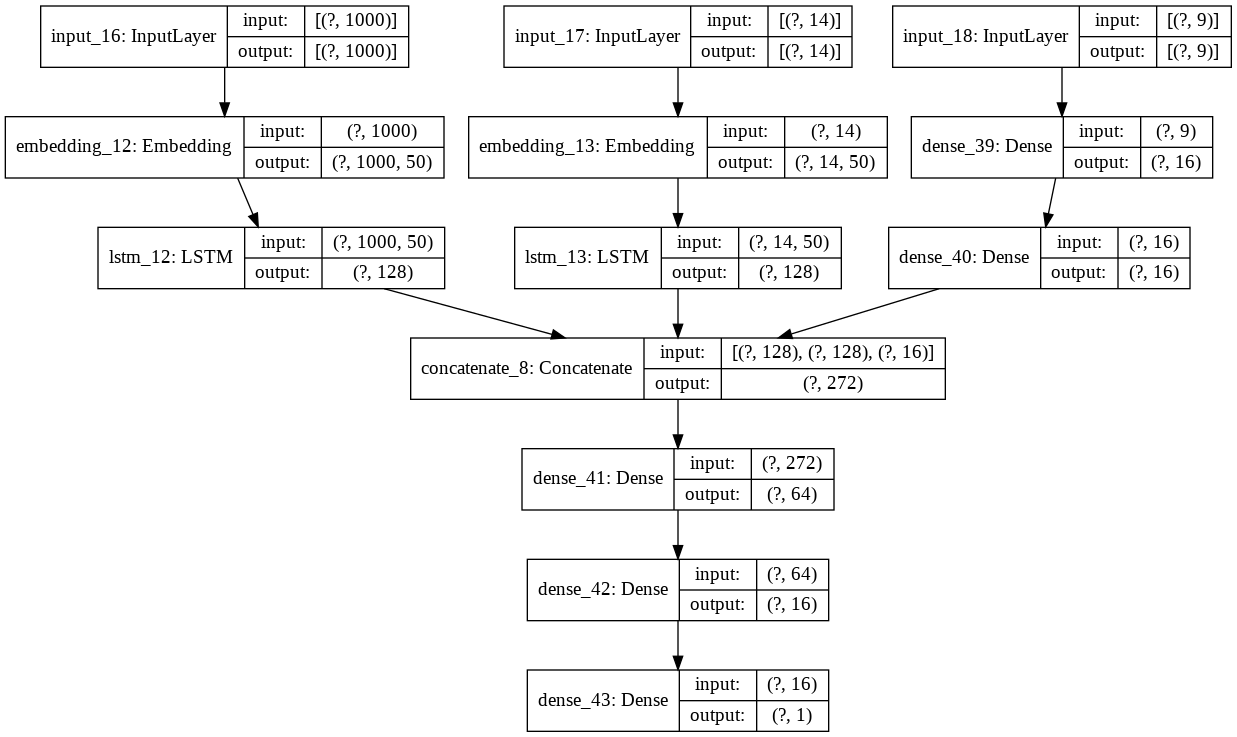

In [196]:
#the network diagram of the first part of the  mixed input model
from keras.utils import plot_model
plot_model(mixed_input, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [189]:
columnsToKeep

['responsesCreatedCount',
 'wordCount',
 'titleLength',
 'imageCount',
 'language_other',
 'publication_TDS',
 'publication_author',
 'publication_others',
 'publication_NT']

In [197]:
filepath="/drive/My Drive/Colab_Data_Files/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [199]:
history = mixed_input.fit(x=[train_int_body,train_int_title, X_train[columnsToKeep]], y=y_lr_train, batch_size=128, epochs=3, verbose=1, callbacks=callbacks_list, 
                    validation_split=0.3)

Epoch 1/3
317/317 [==============================] - ETA: 0s - loss: 0.5646 - acc: 0.6994
Epoch 00001: val_loss improved from -inf to 0.53944, saving model to /drive/My Drive/Colab_Data_Files/weights-improvement-01-0.54.hdf5
317/317 [==============================] - 1019s 3s/step - loss: 0.5646 - acc: 0.6994 - val_loss: 0.5394 - val_acc: 0.7144
Epoch 2/3
317/317 [==============================] - ETA: 0s - loss: 0.5275 - acc: 0.7258
Epoch 00002: val_loss did not improve from 0.53944
317/317 [==============================] - 1012s 3s/step - loss: 0.5275 - acc: 0.7258 - val_loss: 0.5249 - val_acc: 0.7239
Epoch 3/3
317/317 [==============================] - ETA: 0s - loss: 0.5143 - acc: 0.7347
Epoch 00003: val_loss did not improve from 0.53944
317/317 [==============================] - 1020s 3s/step - loss: 0.5143 - acc: 0.7347 - val_loss: 0.5180 - val_acc: 0.7319


In [200]:
y_test_pred_mixed_1=mixed_input.predict([test_int_body,test_int_title,X_test[columnsToKeep]])

In [201]:
from sklearn.metrics import confusion_matrix

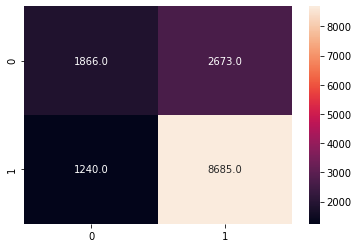

In [202]:
cf_matrix = confusion_matrix(y_lr_test, y_test_pred_mixed_1>0.5)
sns.heatmap(cf_matrix,annot=True, fmt=".1f")

**MIXED INPUT MODEL - REGRESSION**

In [213]:
#in the second part only the training records which has more than 0 clap is considered
i = np.where(y_train>0)
train_int_body_reg=train_int_body[i]#body of the text
train_int_title_reg=train_int_title[i]#body of the text
X_train_reg=X_train.loc[i]#tabular data
y_train_reg=y_train[y_train>0]#target

In [235]:
input_1 = Input(shape=(max_body_length,))

input_2 = Input(shape=(max_title_length,))

input_3 = Input(shape=(9,))

In [236]:
embedding_layer_1 = Embedding(NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix_body], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer_1)

In [237]:
embedding_layer_2 = Embedding(size_of_vocabulary_title, EMBEDDING_DIM, weights=[embedding_matrix_title], trainable=False)(input_2)
LSTM_Layer_2 = LSTM(128)(embedding_layer_2)

In [238]:
dense_layer_1 = Dense(16, activation='relu')(input_3)
dense_layer_2 = Dense(16, activation='relu')(dense_layer_1)

In [239]:
concat_layer = Concatenate()([LSTM_Layer_1,LSTM_Layer_2, dense_layer_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(1, activation='relu')(dense_layer_3)
mixed_input_final = Model(inputs=[input_1, input_2,input_3], outputs=output)

In [240]:
mixed_input_final.compile(loss='mse', optimizer='adam', metrics=['mse'])
print(mixed_input_final.summary())

Model: "functional_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 1000)]       0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 14)]         0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 1000, 50)     500000      input_31[0][0]                   
______________________________________________________________________________________

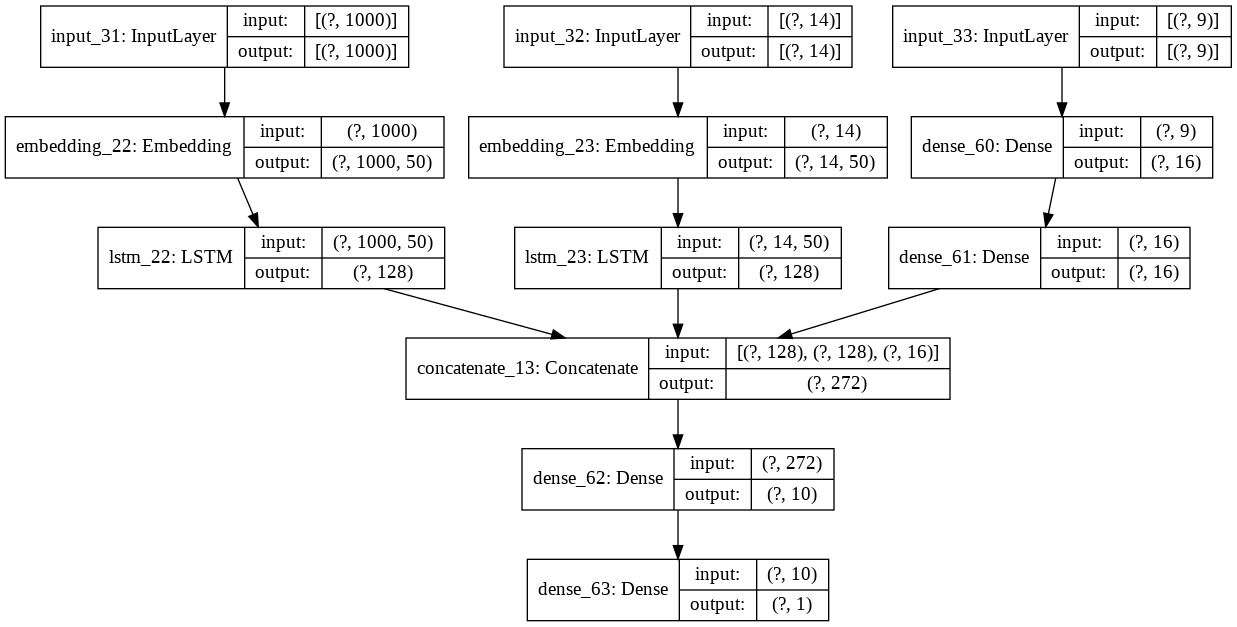

In [241]:
plot_model(mixed_input_final, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [243]:
history = mixed_input_final.fit(x=[train_int_body_reg,train_int_title_reg, X_train_reg[columnsToKeep]], y=y_train_reg, batch_size=128, epochs=3, verbose=1, 
                    validation_split=0.3)

Epoch 1/3
216/216 [==============================] - 691s 3s/step - loss: 1570795.7500 - mse: 1570795.7500 - val_loss: 2058244.5000 - val_mse: 2058244.5000
Epoch 2/3
216/216 [==============================] - 695s 3s/step - loss: 1544750.2500 - mse: 1544750.2500 - val_loss: 2047932.8750 - val_mse: 2047932.8750
Epoch 3/3
216/216 [==============================] - 701s 3s/step - loss: 1537771.6250 - mse: 1537771.6250 - val_loss: 2040766.7500 - val_mse: 2040766.7500


In [244]:
y_test_pred_mixed_2=mixed_input.predict([test_int_body,test_int_title,X_test[columnsToKeep]])

In [245]:
y_test_pred_mixed_final=y_test_pred_mixed_2*y_test_pred_mixed_1

In [248]:
mse_mixed_final=metrics.mean_squared_error((y_test), (y_test_pred_mixed_final)) 
mse_mixed_final

994720.9445708467

In [266]:
MSE['mixed_final']=mse_mixed_final

The best performing model is the second one, i.e. neural network with only tabular data. Glove performs slightly better than training the embeddings in an LSTM network. Unfortunately, the mixed input model gives the worst results. I will use second model to predict the test set target variable. Although the purpose of the assignment is to create a good prediction model with text data, tabular data alone performs much better than text data alone or text data combines tabular data. Therefore, I will calculate claps based on the neural network model with only tabular data 

In [267]:
MSE

,LogLin,nn_Only_Tabular,onlyText,onlyText_Glove,mixed_final
0,573939.833636,544286.875,987221.3125,970920.4375,994720.944571


In [285]:
final_predictions['index']=range(0,514)

In [286]:
test_2_predictions = NN_model.predict(test_2[columnsToKeep])

In [287]:
final_predictions['Claps']=test_2_predictions

In [288]:
final_predictions

,index,Claps
0,0,57180.285156
1,1,15519.015625
2,2,11525.935547
3,3,6628.435547
4,4,1026.258057
...,...,...
509,509,21707.470703
510,510,1248.196411
511,511,663.407349
512,512,9954.337891


In [291]:
final_predictions.to_csv(DATA_DIR+"finalPredictions.csv")